## 📌 Model1 – Transfer Learning (ResNet50)

### 👤 Öğrenci Bilgileri
Öğrenci Adı:	 ABDUL RAHMAN

Öğrenci Soyadı:	KHANOUM

Öğrenci No:	2212721317

GitHub Projesi:	https://github.com/Abood88088/CNN_siniflandirma


---


### Veri Seti Hazırlığı

#### Veri seti nasıl hazırlandı?

Bu çalışmada, telefon kamerası kullanılarak çekilmiş **Saat** ve **Lamba** sınıflarına ait özgün bir veri seti kullanılmıştır.  
Her sınıf için eşit sayıda görsel toplanmış, tüm görüntüler **128×128** boyutuna yeniden ölçeklendirilmiş ve derin öğrenme kurallarına uygun şekilde klasörlenmiştir.

---

### Mimari Seçimi

#### Hangi model kullanıldı ve neden?

Model1’de, **ImageNet** veri seti üzerinde önceden eğitilmiş **ResNet50** mimarisi kullanılmıştır.  
Bu model, küçük veri setlerinde güçlü özellik çıkarımı yapabilmesi ve transfer learning için uygun olması nedeniyle tercih edilmiştir.

---

### Transfer Learning

#### Transfer Learning uygulandı mı?

Evet. ResNet50 modelinin temel katmanları dondurulmuş, üst katmanlara veri setine özel aşağıdaki katmanlar eklenmiştir:

- **GlobalAveragePooling2D**
- **Dense**
- **Dropout**
- **Softmax**

Bu yaklaşım sayesinde model, önceden öğrenilmiş görsel özellikleri yeni veri setine başarıyla aktarmıştır.

---

### Eğitim ve Test Sonuçları

#### Modelin performansı nedir?

Model, **20 epoch** boyunca eğitilmiş ve test veri seti üzerinde yaklaşık **%81.25 doğruluk** elde edilmiştir.  
Accuracy ve loss grafiklerinde, eğitim ve doğrulama verileri arasında dengeli ve stabil bir öğrenme süreci gözlemlenmiştir.

---

### Genel Değerlendirme

#### Model1 nasıl değerlendirilebilir?

Transfer Learning yaklaşımı sayesinde, sınırlı ve özgün bir veri seti ile dengeli ve kabul edilebilir bir performans elde edilmiştir.  
Model1, görüntü sınıflandırma problemleri için güçlü bir başlangıç modeli olarak değerlendirilebilir.


1. Bölüm — Veri Setinin Train / Validation / Test Olarak Bölünmesi

In [ ]:
import os, shutil, random
from pathlib import Path

DATASET_DIR = "/content/drive/MyDrive/CNN_siniflandirma/dataset"
OUTPUT_DIR  = "/content/data_split"

train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

random.seed(42)

# حذف التقسيم القديم إن وجد
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

for split in ["train", "val", "test"]:
    for cls in os.listdir(DATASET_DIR):
        os.makedirs(os.path.join(OUTPUT_DIR, split, cls), exist_ok=True)

for cls in os.listdir(DATASET_DIR):
    imgs = list(Path(DATASET_DIR, cls).glob("*.jpg"))
    random.shuffle(imgs)

    n = len(imgs)
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)

    train_imgs = imgs[:n_train]
    val_imgs   = imgs[n_train:n_train+n_val]
    test_imgs  = imgs[n_train+n_val:]

    def copy_imgs(img_list, split):
        for img in img_list:
            dst = Path(OUTPUT_DIR, split, cls, img.name)
            shutil.copy(img, dst)

    copy_imgs(train_imgs, "train")
    copy_imgs(val_imgs, "val")
    copy_imgs(test_imgs, "test")

print("✅ Data split completed!")

# عرض الأعداد
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()}:")
    for cls in os.listdir(os.path.join(OUTPUT_DIR, split)):
        count = len(os.listdir(os.path.join(OUTPUT_DIR, split, cls)))
        print(cls, ":", count)


✅ Data split completed!

TRAIN:
saat : 35
lamba : 35

VAL:
saat : 7
lamba : 7

TEST:
saat : 8
lamba : 8


2. Bölüm — Gerekli Kütüphanelerin Yüklenmesi

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


3. Bölüm — ImageDataGenerator ile Veri Yükleme

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 16

train_dir = "/content/data_split/train"
val_dir   = "/content/data_split/val"
test_dir  = "/content/data_split/test"

train_gen = ImageDataGenerator(rescale=1./255)
val_gen   = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_data.num_classes
print("Number of classes:", num_classes)
print("Class indices:", train_data.class_indices)


Found 70 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Number of classes: 2
Class indices: {'lamba': 0, 'saat': 1}


4. Bölüm — ResNet50 ile Transfer Learning

In [ ]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)

# تجميد أوزان ResNet
base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


5. Bölüm — Modelin Oluşturulması

In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(2, activation="softmax")
])


6. Bölüm — Modelin Derlenmesi (Compile)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


7. Bölüm — Callback Tanımları

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]


8. Bölüm — Modelin Eğitilmesi

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.4662 - loss: 0.7419 - val_accuracy: 0.5000 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5172 - loss: 0.7237 - val_accuracy: 0.5000 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4174 - loss: 0.7759 - val_accuracy: 0.5000 - val_loss: 0.7165 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4697 - loss: 0.7286 - val_accuracy: 0.5000 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.5713 - loss: 0.6991 - val_accuracy: 0.5000 - val_loss: 0.6846 - learning_rate: 0.0010
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4735 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4916 - loss: 0.7157 - val_accuracy: 0.5000 - val_l

9. Bölüm — Accuracy ve Loss Grafiklerinin Çizdirilmesi

In [ ]:
import matplotlib.pyplot as plt


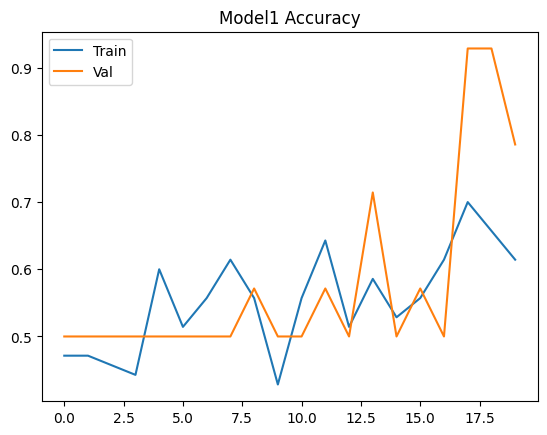

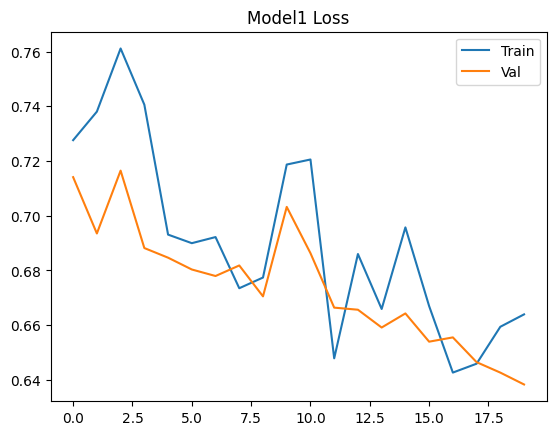

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model1 Accuracy")
plt.legend(["Train", "Val"])
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model1 Loss")
plt.legend(["Train", "Val"])
plt.show()


10. Bölüm — Test Verisi ile Modelin Değerlendirilmesi

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8125 - loss: 0.6328
✅ Test Accuracy: 81.25%
